# Прикладная статистика.
# Академия Аналитиков Авито
# Досдача заданий "на зачёт"

# Home Work 2

## Задача 1 (1 балл)

### На зачет

Пусть $x_1, ... x_N$ — реализация выборки $\xi_1, ... \xi_N \sim \mathcal{N}(\mu,\sigma)$. Мы хотим проверить гипотезу:
- $H_0: \mu = \mu_0$
- $H_1: \mu \neq \mu_0$

Реализовать критерий Стьюдента — функцию `simple_my_t_test(sample, mu_0, alpha)`. Функция должна вернуть `SimpleMyTtestResults` с полями
- is_rejected: отверглась или нет гипотеза H_0 на уровне значимости alpha
- pvalue

Какие библиотеки можно использовать:

```
import numpy as np
from collections import namedtuple
import math
from scipy.stats import t
```

In [1]:
import numpy as np
from collections import namedtuple
import math
from scipy.stats import t

**Важно:** что ее решение надо объяснить! Можно не вдаваться в детали, но ваш алгоритм надо описать текстом.

### Решение

Выборка из нормального распределения, применяем т-тест. Статистика для одновыборочного критерия Стьюдента: 

$$T(X) = \sqrt{n}\dfrac{\overline X - \mu_0}{\sqrt{S^2}}$$

где $S^2$ - это несмещенная состоятельная оценка дисперсии:

$$S^2 = \dfrac{1}{n - 1}\underset{i=1}{\overset{n}{\sum}}(X_i - \overline X)^2$$ 
 
Считаем значение статистики и находим соответствующее значение pvalue из таблицы или в нашем случае с помощью функции t из scipy.stats. Также не забываем, что стпеней свободы = n - 1.

Гипотезы поставлены так, что будем использовать двувыборочный t-test =>

$$pvalue = 2 \cdot min(F_{n-1}(t), 1 - F_{n-1}(t))$$ где t - реализация статистики $T(X)$

In [2]:
# Автопроверка

MySimpleTtestResults = namedtuple('MySimpleTtestResults', 
                                  ['is_rejected', 'pvalue'])

def my_simple_t_test(sample: list, mu_0: float, alpha: float = 0.05):
    """
    Параметры:
    - sample: текущая реализация выборки
    - mu_0: мат. ожидание выборки при H_0
    - alpha: уровень значимости критерия.
        
    Возвращает:
    - MySimpleTtestResults с полями:
        - is_rejected: bool
            - отверглась или нет гипотеза H_0 на уровне значимости alpha
        - pvalue: float
    """

    is_rejected = None
    pvalue = None
    
    size = len(sample)
    t_statistics = (np.mean(sample) - mu_0) / (np.var(sample, ddof=1) / size) ** 0.5 
    
    pvalue_one_sided = 1 - t(size - 1).cdf(t_statistics)
    
    
    if pvalue_one_sided > 0.5:
        pvalue_one_sided = t(size - 1).cdf(t_statistics)
        
    pvalue = 2 * pvalue_one_sided
    
    if pvalue > 1:
        pvalue = 1
    
    
    if pvalue > alpha:
        is_rejected = False
    else:
        is_rejected = True

        
    return MySimpleTtestResults(is_rejected, pvalue)

## Задача 3 (4 балла)

### На зачет

**1. (0.5 баллов)**

Написать код для проверки критерия при корректности $H_0$:

- Зафиксировать $\mu = 0,\ \mu_0 = 0$ ($H_0$ справедлива)
- Зафиксировать $n, \sigma, \alpha$ на ваше усмотрение
- 10000 раз повторить:
    
    –сгенереровать выборку $x_1,..., x_n$ из $\mathcal{N}(\mu, \sigma)$
    
    –вызвать для нее `my_simple_t_test(sample, mu_0, alpha)`
    
    –на основании выдачи функции принять или не принять $H_1$
- замерить долю ошибок первого рода (False Positive Rate)
- Проверить, стат значимо или нет на уровне 5% отличается полученный процент ошибок от теоретического $\alpha$.


**2. (1.5 балла)**

Провести эксперимент 1 с разными параметрами $n, \sigma, \alpha$.
Оформить отчет о результатах c графиками, комментариями и выводами.

--- 
**3. (0.5 баллов)**

Написать код для проверки критерия при корректности $H_1$:

- Зафиксировать $\mu \neq 0,\ \mu_0 = 0$ ($H_1$ справедлива)
- Зафиксировать $n, \sigma, \alpha$ на ваше усмотрение
- 10000 раз повторить:
    
    –сгенереровать выборку $x_1,..., x_n$ из $\mathcal{N}(\mu, \sigma)$
    
    –вызвать для нее `my_simple_t_test(sample, mu_0, alpha)`
    
    –на основании выдачи функции принять или не принять $H_1$
- замерить долю ошибок второго рода (False Negative Rate)
- Построить доверительный интервал для мощности критерия при заданном $\mu$.

**2. (1.5 балла)**

Провести предыдущий эксперимент с разными параметрами $\mu, n, \sigma, \alpha$.
Оформить отчет о результатах c графиками, комментариями и выводами.

### Решение

В данной задаче предлагается реализовать метод Монте-Карло для различных кейсов, приступим:

In [3]:
from statsmodels.stats.proportion import proportion_confint
from scipy.stats import norm

from matplotlib import pyplot as plt

#### Первый пункт

In [4]:
def check_criterion_FPR(test_dist, mu_0, sample_size, N_exps=10_000, alpha=0.05, to_print=True):
    
    """
    Функция для проверки одновыборочного t-test критерия 
    Возвращает доверительный интервал для FPR, если флаг to_print = False. Иначе печатает результат.

    Параметры:
        - test_dist: распределение тестовой выборки в эксперименте
        - mu: мат. ожидание при нулевой гипотезе
        - sample_size: размер выборки теста
        - N_exps: число экспериментов, по которым потом считается FPR
        - alpha: рассматриваемый fpr
        - to_print: печатать результат или нет. Если нет, то функция возвращает дов. интервал для FPR.
    """
    
    bad_cnt = 0
    for i in range(N_exps):
        
        # Генерируем выборку
        test = test_dist.rvs(sample_size)
        
        # Запускаем критерий и считаем p-value
        pvalue = my_simple_t_test(test, mu_0, alpha).pvalue
        
        # Проверяем, что pvalue < alpha
        bad_cnt += (pvalue < alpha)
        
        
    if to_print:
        print(f"FPR: {round(bad_cnt / N_exps, 4)}")
        print(f"CI={proportion_confint(count = bad_cnt, nobs = N_exps, alpha=0.05, method='wilson')}")
    else:
        return round(bad_cnt / N_exps, 4), proportion_confint(count = bad_cnt, nobs = N_exps, alpha=0.05, method='wilson')

In [5]:
mu_0 = 0
sigma = 0.1
test_dist = norm(loc=mu_0, scale=sigma)

check_criterion_FPR(test_dist=test_dist, mu_0=mu_0, sample_size=1_000, N_exps=10_000, alpha=0.05, to_print=True)

FPR: 0.0494
CI=(0.04532304560552551, 0.05382301372612823)


Значение 0.05 лежит в доверительном интервале, что говорит нам о том, что скорее всего алгоритм написан верно, что хорошо.

#### Второй пункт

In [6]:
def plot_figure_with_ci(param, fpr_values, ci_values, vis=0.1):
    plt.figure(figsize=(12, 6))
    plt.plot(param, fpr_values)
    plt.fill_between(param, np.array(ci_values)[:, 0], np.array(ci_values)[:, 1], alpha=vis)
    plt.show()

##### Меняем параметр n

In [7]:
fpr_values = []
ci_values = []

n = [2, 5, 10, 50, 100, 500, 1_000, 5_000]

mu_0 = 0
sigma = 0.1
test_dist = norm(loc=mu_0, scale=sigma)

for sample_size in n:
    result = check_criterion_FPR(test_dist=test_dist, 
                                  mu_0=mu_0, 
                                  sample_size=sample_size, 
                                  N_exps=10_000, 
                                  alpha=0.05, 
                                  to_print=False)
    fpr_values.append(result[0])
    ci_values.append([*result[1]])

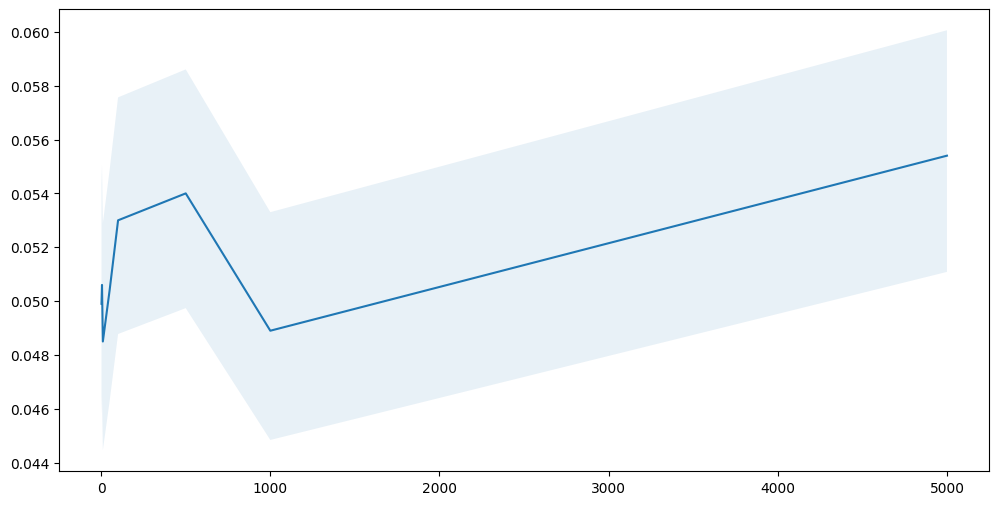

In [8]:
plot_figure_with_ci(n, fpr_values, ci_values)

Так как мы рассматриваем выборку из нормального распределения, то по теории, мы никак не должны зависеть от количества элементоов в выборке, что мы и видим, значение fpr=0.05 есть всегда в доверительном интервале.

##### Меняем параметр sigma

In [9]:
fpr_values = []
ci_values = []

sigmas = [0.00001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
mu_0 = 0

for sigma in sigmas:
    test_dist = norm(loc=mu_0, scale=sigma)
    result = check_criterion_FPR(test_dist=test_dist, 
                                  mu_0=mu_0, 
                                  sample_size=1_000, 
                                  N_exps=10_000, 
                                  alpha=0.05, 
                                  to_print=False)
    fpr_values.append(result[0])
    ci_values.append([*result[1]])

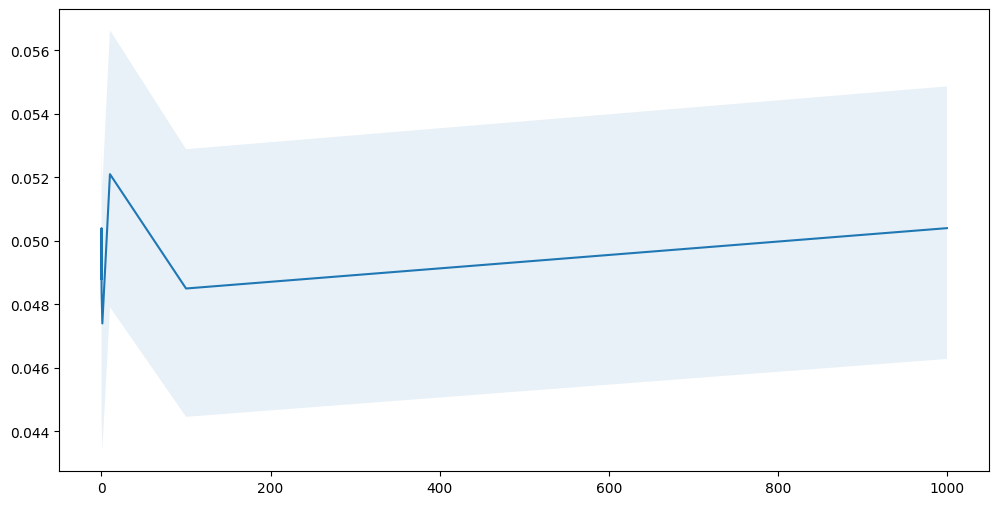

In [10]:
plot_figure_with_ci(sigmas, fpr_values, ci_values)

От стандартного отклонения тоже не должно было быть зависимости, что мы наблюдаем на графике, доверительный интервал содержит значение 0.05 везде. 

Может так показаться, что значение уменьшаются, но это лишь только из-за того, что есть дискретность значений и интервал между некоторым совсем малый, а между другими на сотни раз больше.

##### Меняем параметр alpha

In [11]:
fpr_values = []
ci_values = []

alphas = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 0.9]
sigma = 0.1
mu_0 = 0

test_dist = norm(loc=mu_0, scale=sigma)

for alpha in alphas:
    result = check_criterion_FPR(test_dist=test_dist, 
                                  mu_0=mu_0, 
                                  sample_size=1_000, 
                                  N_exps=10_000, 
                                  alpha=alpha, 
                                  to_print=False)
    fpr_values.append(result[0])
    ci_values.append([*result[1]])

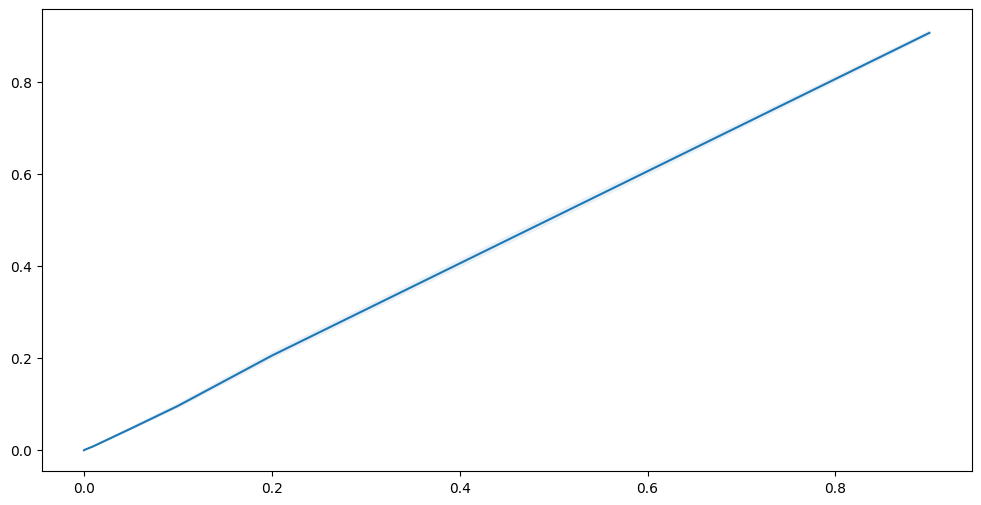

In [12]:
plot_figure_with_ci(alphas, fpr_values, ci_values, vis=0.1)

Критерий отрабатывает правильно и показывает такой fpr, который мы задаем, что говорит нам линейный график.

#### Третий пункт

In [13]:
def check_criterion_TPR(test_dist, mu_0, sample_size, N_exps=1000, alpha=0.05, to_print=True):
    
    """
    Функция для проверки одновыборочного t-test критерия 
    Возвращает доверительный интервал для FPR, если флаг to_print = False. Иначе печатает результат.

    Параметры:
        - test_dist: Распределение тестовой выборки в эксперименте
        - mu_0: мат. ожидание гипотезы, если H_0 верна
        - sample_size: размер тестовой выборки
        - N_exps: число экспериментов, по которым потом считается FPR
        - to_print: печатать результат или нет. Если нет, то функция возвращает дов. интервал для FPR.
    """
    
    rej_cnt = 0
    for i in range(N_exps):
        
        # Генерируем выборку
        test = test_dist.rvs(sample_size)
        
        # Запускаем критерий и считаем p-value
        pvalue = my_simple_t_test(test, mu_0, alpha).pvalue
        
        # Проверяем, что pvalue < alpha
        rej_cnt += (pvalue < alpha)
        
    if to_print:
        print(f"TPR: {round(rej_cnt / N_exps, 4)}")
        print(f"CI={proportion_confint(count = rej_cnt, nobs = N_exps, alpha=0.05, method='wilson')}")
    else:
        return round(rej_cnt / N_exps, 4), proportion_confint(count = rej_cnt, nobs = N_exps, alpha=0.05, method='wilson')

In [14]:
mu_0 = 0
mu = mu_0 + 0.01
sigma = 0.1
test_dist = norm(loc=mu, scale=sigma)

check_criterion_TPR(test_dist=test_dist, mu_0=mu_0, sample_size=1_000, N_exps=10_000, alpha=0.05, to_print=True)

TPR: 0.8824
CI=(0.8759389555612356, 0.8885673624848709)


С первого взгляда критерий отрабатывает очень даже корректно, показывает очень хорошую можность при таких парметрах, которые дают достаточно сильное отклонение среднего в соотношении к десперсии.

#### Четвертый пункт

##### Меняем параметр mu

In [15]:
tpr_values = []
ci_values = []

delta = 0.001


mu_0 = 0
mus = np.array([-delta*100, -delta*10, -delta, delta, delta*10, delta*100]) + mu_0
sigma = 0.1

for mu in mus:
    test_dist = norm(loc=mu, scale=sigma)
    result = check_criterion_TPR(test_dist=test_dist, 
                                  mu_0=mu_0, 
                                  sample_size=1_000, 
                                  N_exps=10_000, 
                                  alpha=0.05, 
                                  to_print=False)
    tpr_values.append(result[0])
    ci_values.append([*result[1]])

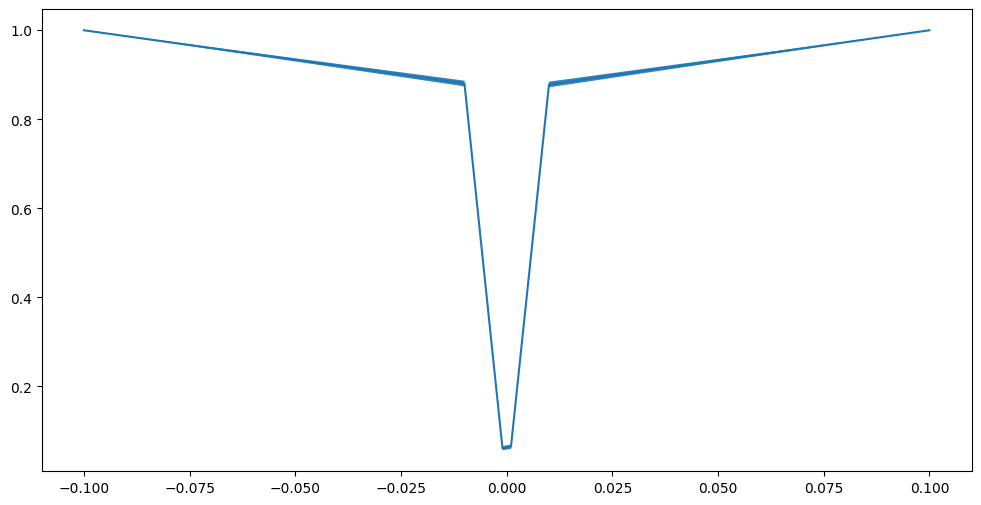

In [16]:
plot_figure_with_ci(mus, tpr_values, ci_values, vis=0.9)

Если отклонение от mu_0 малы, тогда и мощность тоже мала, что логично, алгоритму очень сложно заметить очень малые отклонения.

При увеличении разности mu - mu_0, tpr возрастает

А также видно, что неважно в какую сторону было отклонение.

##### Меняем параметр n

In [17]:
tpr_values = []
ci_values = []

n = [2, 5, 10, 50, 100, 500, 1_000, 5_000]

mu_0 = 0
mu = mu_0 + 0.01
sigma = 0.1
test_dist = norm(loc=mu, scale=sigma)

for sample_size in n:
    result = check_criterion_TPR(test_dist=test_dist, 
                                  mu_0=mu_0, 
                                  sample_size=sample_size, 
                                  N_exps=10_000, 
                                  alpha=0.05, 
                                  to_print=False)
    tpr_values.append(result[0])
    ci_values.append([*result[1]])

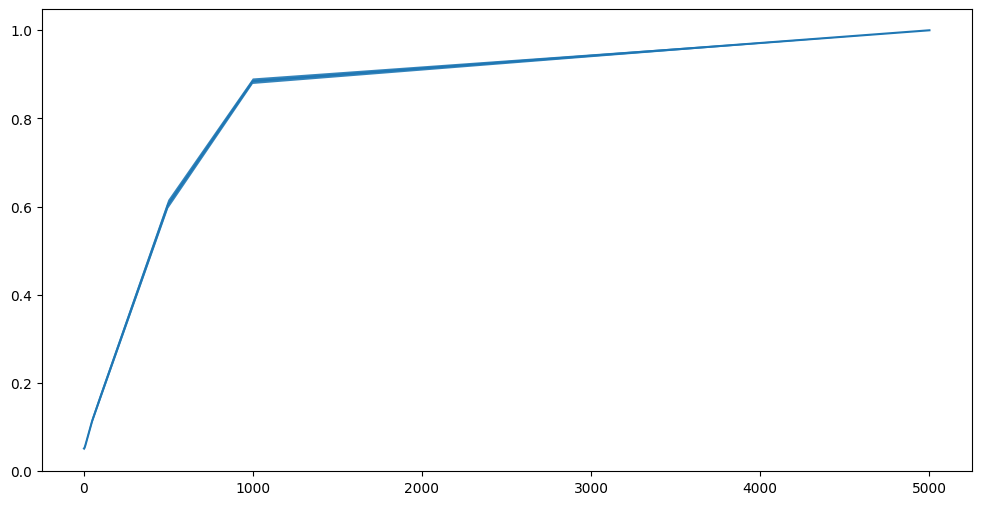

In [18]:
plot_figure_with_ci(n, tpr_values, ci_values, vis=0.9)

Тут мы видими, что при росте выборки tpr возрастает, что в принципе логично.

##### Меняем параметр sigma

In [19]:
tpr_values = []
ci_values = []

sigmas = [0.00001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
mu_0 = 0
mu = mu_0 + 10

for sigma in sigmas:
    test_dist = norm(loc=mu, scale=sigma)
    result = check_criterion_TPR(test_dist=test_dist, 
                                  mu_0=mu_0, 
                                  sample_size=1_000, 
                                  N_exps=10_000, 
                                  alpha=0.05, 
                                  to_print=False)
    tpr_values.append(result[0])
    ci_values.append([*result[1]])

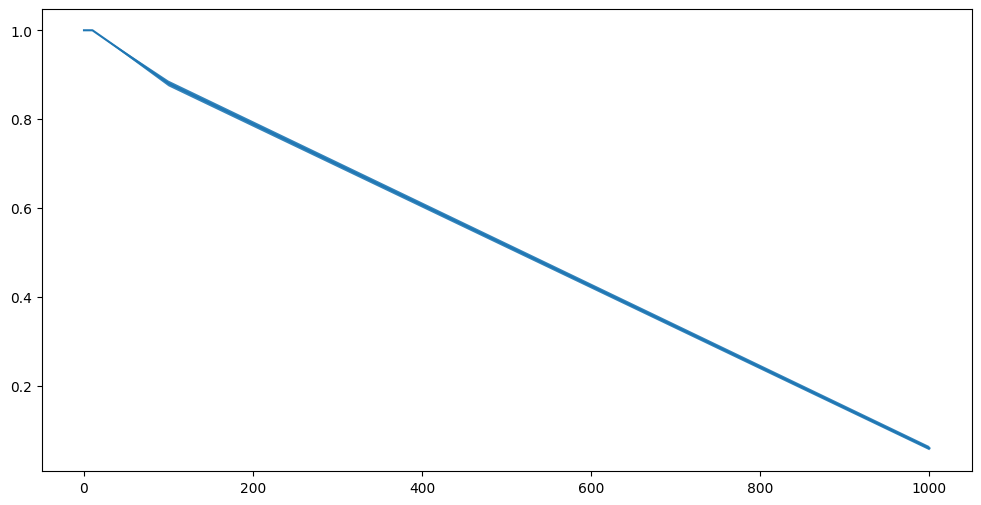

In [20]:
plot_figure_with_ci(sigmas, tpr_values, ci_values, vis=0.9)

Тут видим сильную зависимость, чем больший разброс в данных, тем меньше мощность критерия.

##### Меняем параметр alpha

In [21]:
tpr_values = []
ci_values = []

alphas = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 0.9]

mu_0 = 0
mu = mu_0 + 0.01
sigma = 0.1
test_dist = norm(loc=mu, scale=sigma)

for alpha in alphas:
    result = check_criterion_TPR(test_dist=test_dist, 
                                  mu_0=mu_0, 
                                  sample_size=1_000, 
                                  N_exps=10_000, 
                                  alpha=alpha, 
                                  to_print=False)
    tpr_values.append(result[0])
    ci_values.append([*result[1]])

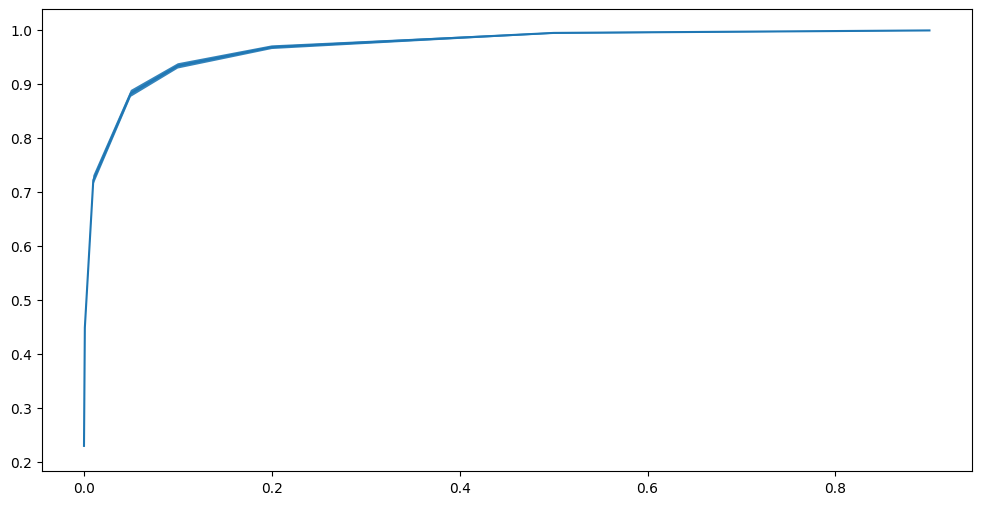

In [22]:
plot_figure_with_ci(alphas, tpr_values, ci_values, vis=0.9)

Тут опять же всё логично, чем больше уровень значимости, тем больше мощность.

## Задача 4 (2 балла)

### На зачет

Петя скачал себе новую игру себе на телефон. Чтобы начать в нее играть, она должна загрузиться от 0% до 100%, где каждый процент игры загружается независимо ни от чего, и время загрузки каждого процента подчиняется экспоненциальному распределению со средним в 2 сек. Но вот незадача: через 3 минуты Пете надо бежать на автобус к бабушке в деревню, а в дороге Петя хочет уже поиграть( Но игра может скачаться только при подключенном домашнем WI-FI, то есть только только в течение этих 3 минут. С какой вероятностью игра успеет загрузиться и Петя сможет поиграть в дороге? В ответе можно использовать следующие функции распределения:

- Экспоненциальное
- Нормальное
- Равномерное



### Решение

Каждый процент игры загружается независимо ни от чего, и время загрузки каждого процента подчиняется экспоненциальному распределению со средним в 2 сек =>

$$\mu = 1 / \lambda = 2$$
$$\sigma = 1 / \lambda^2 = 4$$

А так как каждый процент загружается незивисимо => мы имеем дело с суммой 100 независимых величин, далее гофорим, что по ЦПТ (мы имеем ей право пользоваться так как имеем дело с достаточно большой последовательностью независимых одинаково распределенных случайных величин, имеющих конечное мат ожидание и дисперсию):

$$\sum_{i=1}^n \sim Norm(n * \mu, n * \sigma^2)$$

$$ n * \mu = 100 \cdot 2 = 200$$
$$ n * \sigma^2 = 100 \cdot 4 = 400$$


Далее применяем функцию cdf к norm(200, 400), указывая парметр - как время, которое нас интересует - 3 минуты = 180 секунд (так как все вычисления у нас в секундах). Не забыть, что в scipy.stats указывают не дисперсию, а стандартное отклонение.

In [23]:
from scipy.stats import norm

def get_prob(n: int, mu_0: float, t: float):
    """
    Параметры:
    - n: количество необходимых для загрузки процентов
    - mu_0: мат. ожидание загрузки одного процента
    - t: время, вероятность загрузки за которое мы хотим найти
        
    Возвращает:
    - вероятность: успеет ли игра загрузиться
    """
    
    distribution = norm(loc=n*mu_0, scale=np.sqrt(n)*mu_0)
    return distribution.cdf(t)* 100

print(f'Вероятность равна: {get_prob(100, 2, 180):.{3}}')

Вероятность равна: 15.9


## Задача 5 (3 балла)

### На зачет

Пусть есть равные группы A и B. По результатам теста выручка от одного пользователя в среднем в условиях A оценивается Стьдентом как 50 ± 3 руб, а в условиях B как 56 ± 4 руб. Аналитик, увидев такие результаты, говорит, что эффект составил 6 ± 7 руб, а значит результат AB-теста не стат. значим. Все ли корректно в этих рассуждениях? Любой ответ должен быть аргументирован. В случае, еcли в рассуждениях есть ошибка, то надо также посчитать корректно доверительный интервал.


### Решение

Что у нас имеется по условию:

- Доверительный интервал для среднего в выборке А 50 ± 3
- Доверительный интервал для среднего в выборке B 56 ± 4

Мы хотим получить доверительный интервал для наблюдаемого эффекта. 

Что нам предлагается вычесть средние и сложить отклонения и получить следующий интервал: 6 ± 7

С получившимся средним (6) согласиться ещё могу, но то, как рассчитан интервал - как будто наобум.

Воспользуемся теорией, которую нам давал Тимур Исмагилов в лекциях:

Применим некий аналог T'-test для двувыборочного критерия (считаем, что выборки большие). Что мы получим:

$$1/M \cdot (B_1 + ... + B_M) - 1/N \cdot (A_1 + ... + A_N) \sim Norm(\mu_B - \mu_A, \sigma^2_A/N + \sigma^2_B/M)$$

Из начальных данных:

$$\mu_B - \mu_A = 56 - 50 = 6$$
$$z_{1-\alpha}^2*S^2_A/N = 3^2$$
$$z_{1-\alpha}^2*S^2_B/M = 4^2$$

И то есть получим, что отклонение для наблюдаемого эффекта равно: $\sqrt{3^2 + 4^ 2} = 5$, тогда мы получили следующий дверительный интервал для наблюдаемого эффекта: $6 \pm 5$.

И уже при таком расчете 0 не входит в доверительный интервал, значит можно говорить, что изменения статистически значимы.

## Задача 6

### Пункт А. 1 балл: 
#### На зачет

Какая связь между MDE и шириной доверительного интервала в t-test уровня значимости $\alpha$? Точнее, между MDE и `CI length / 2` (шириной дов. интервала пополам).

При каких параметрах ($\alpha,\ \beta$) они будут равны?



### Решение

Так, что у нас вообще такое доверительный интервал для t-test:

$$ \overline{X} \pm T^{n-1}_{1-\alpha/2} \cdot SEM(x)$$

где SEM(x) - это стандартная ошибка среднего 
$$SEM(x) =  \sqrt{S^2 / n}$$


Тогда $CI_{length / 2}$ будет определяться как 
$$T^{n-1}_{1-\alpha/2} \cdot SEM(x)$$

А теперь распишем что такое MDE для t-test:
$$MDE = m - m_0 = SEM(x) \cdot (Z_{1-\alpha} + Z_{1-\beta})$$

где $Z_{1-\alpha}, Z_{1-\beta}$ - квантили стандартного нормального распределения

На семинаре Дима Лунин говорил, что мы можем подобрать такой параметр $\beta$, что $MDE = CI / 2$, поэтому буду немного отталкиваться от этой подсказки.

Что получаем:

$$T^{n-1}_{1-\alpha/2} \cdot SEM(x) = SEM(x) \cdot (Z_{1-\alpha} + Z_{1-\beta})$$
$$T^{n-1}_{1-\alpha/2} = (Z_{1-\alpha} + Z_{1-\beta})$$

Далее, если мы перейдем к двувыборочному критерию: 

$$T^{n-1}_{1-\alpha/2} = (Z_{1-\alpha/2} + Z_{1-\beta})$$

А далее говорим, что при больших выборках t-распределние и нормальное почти совпадает, тогда:

$$Z_{1-\alpha/2} = (Z_{1-\alpha/2} + Z_{1-\beta})$$

Последнее можно было интерпертировать как "применяем T'-test"

И в итоге получаем:

$$0 = Z_{1-\beta}$$

In [24]:
norm(loc=0, scale=1).cdf(0)

0.5

Тогда получим при $\\beta=0.5 => CI_{length / 2} = MDE$

Данный ответ мы получили для достаточно больших размеров выборок (когда t-распределение можно аппроксимировать нормальным) и для любых значений $\alpha$

# Home Work 3

## Задача 1 (2 балла)

### На зачет

Мы проводили промо-акцию два раза.

- В первый раз мы отправили 38 писем, из них 26 получателей перешли по ссылке.

- Во второй раз мы отправили уже 98 писем, и из получателей по ссылке перешли 42.

С помощью критерия хи-квадрат определить, насколько значимо изменение CTR между акциями. Можем ли мы делать вывод о том, что информирование во второй промо-акции хуже, чем информирование в первой? Почему?

In [25]:
import pandas as pd

pd.DataFrame(
    [[12, 26, 38], [56, 42, 98], [68, 68, 136]], 
     index=['Первый раз', 'Второй раз', 'Всего'], 
     columns=['Не перешли', 'Перешли', 'Всего'],
)

,Не перешли,Перешли,Всего
Первый раз,12,26,38
Второй раз,56,42,98
Всего,68,68,136


Объём выборки в первом и втором случае достаточно большой >=30, также частота каждой ячейки >=10, что дает нам возможность использовать критерий хи-квадрат без поправок.

Так как у нас распределение дискретное, и так как мы сравниваем два эмпирических распределения, тогда число степеней свободы будет равно (кол-во столбцов - 1)(кол-во строк - 1) = (2 - 1)(2 - 1) = 1

При уровне значимости 0.05 проверим следующую гипотезу:

$\textbf{H_0:}$ сущеественных различий между первым и вторым разом проведения акции нет. CTR существенно не различается от раза проведения акции<br>
$\textbf{H_1:}$ различия есть

Посторим таблицу с теоретическими частотами:

In [26]:
pd.DataFrame(
    [[68*38/136, 68*38/136, 38], [68*98/136, 68*98/136, 98], [68, 68, 136]], 
     index=['Первый раз', 'Второй раз', 'Всего'], 
     columns=['Не перешли', 'Перешли', 'Всего'],
)

,Не перешли,Перешли,Всего
Первый раз,19.0,19.0,38
Второй раз,49.0,49.0,98
Всего,68.0,68.0,136


Далее мы можем рассчитать эмперическое значение критерия - $\chi^2_{эмп} = \sum^n_{i=1}(X_{1} - X_{2})^2 / X_{2}$

In [27]:
print('Эмпирическое значение критерия:', (12 - 19)**2/19 + (26 - 19)**2/19 + (56 - 49)**2/49 + (42 - 49)**2/49)
print('Теоретическое значение критерия (критическое значение) при уровне значимости alpha = 0.05:', 3.84)

Эмпирическое значение критерия: 7.157894736842105
Теоретическое значение критерия (критическое значение) при уровне значимости alpha = 0.05: 3.84


Так как эмпирическое значение больше критического, следовательно, мы склоняемся в сторону альтернативной гипотезы: различия между проведениями акции есть. О выполнении гипотезы $H_0$ ничего сказать нельзя

Решим тоже самое при помощи библиотеки **scipy**:

In [28]:
from scipy import stats

stats.chi2_contingency([[12, 26], [56, 42]], correction=False)

Chi2ContingencyResult(statistic=7.157894736842105, pvalue=0.007463474476521292, dof=1, expected_freq=array([[19., 19.],
       [49., 49.]]))

In [29]:
stats.chi2_contingency([[12, 26], [56, 42]], correction=True)

Chi2ContingencyResult(statistic=6.171858216971, pvalue=0.012979820360836461, dof=1, expected_freq=array([[19., 19.],
       [49., 49.]]))

Можно заметить, что таблица частот получилась абсолютно такой же.

Значение статистики хи-квадрат такое же.

pvalue = 0.012979820360836461

Были поставлены следующие вопросы:<br>
_С помощью критерия хи-квадрат определить, насколько значимо изменение CTR между акциями. Можем ли мы делать вывод о том, что информирование во второй промо-акции хуже, чем информирование в первой? Почему?_

**Вывод:** С помощью критерия хи-квадрат мы определили, что есть существенные различия между акциями. 

Мы знаем, оценка максимального правдоподобия конверсии в случае correction=True больше, чем при correction=False. А значит 𝑝1 > 𝑝2.

P.S.
При всём наш способ проверки не внушает доверие, так как сравниваемые частоты были не одного размера. А также из условия не очень понятно, если это были зависимые сопоставлемые группы, то такой тест не следовало бы проводить.

# Home Work 4

## Задача 1 (3 балла)

### На зачет


Пусть дана выборка из непрерывной случайной величины $\xi$.
Разработать односторонний аналог критерия Манна-Уитни для проверки
гипотезы:
- $H_0$: медиана случайной величины $\xi$ равна m0
- $H_1$: медиана случайной величины $\xi$ больше m0

Критические области статистики этого критерия нужно определить с помощью формулы, Монте-Карло процесс для их нахождения не допускается.

Используемые библиотеки:

```
import numpy as np
from collections import namedtuple
from scipy.stats.binom import cdf
from scipy.stats.norm import cdf
from scipy.stats.t import cdf
from scipy.stats.bernoulli import cdf
```

**При этом нельзя пользоваться функцией rvs!**

In [30]:
import numpy as np
from collections import namedtuple
from scipy.stats import binom
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import bernoulli

**Также, прежде чем приступить к написанию кода, распишите алгоритм и докажите корректность вашего критерия!**

При разборе домашки Дима Лунин упомянул, что задачу можно свести к Бернуллевской, отсюда сразу вытекает решение:

- Из каждой величины выборки мы вычтем преполагаемое значение медианы m0
- А далее будем смотреть на знаки величин в выборке
- Если это действительно медиана, то положительных величин около 50%, то есть веротность их обнаружить 0.5
- Если истинная медиана меньше, то вероятность обнаружить меньше 0.5 и наоборот
- Отсюда можем построить, например следующий критерий

- $H_0$: p=0.5
- $H_1$: p>0.5

Теперь переходите к реализации критерия:

In [31]:
#Автопроверка

MyMedianTestResults = namedtuple('MyMedianTestResults', 
                                  ['is_rejected', 'pvalue'])

def median_test(sample: list, mu_0: float, alpha: float = 0.05):
    """
    Параметры:
    - sample: текущая реализация выборки
    - mu_0: медиана выборки при H_0
    - alpha: уровень значимости критерия.
        
    Возвращает:
    - MyMedianTestResults с полями:
        - is_rejected: bool
            - отверглась или нет гипотеза H_0 на уровне значимости alpha
        - pvalue: float
    """

    is_rejected = None
    pvalue = None
    
    ber = np.sign(sample - mu_0)
    N = len(ber)
    
    ber_stat = np.sum(np.where(ber == -1, 0, 1))
    
    p_value_one_sided = 1 - binom.cdf(ber_stat-1, n=N, p=0.5)
        
    pvalue = p_value_one_sided
    is_rejected = True if pvalue <= alpha else False

    return MyMedianTestResults(is_rejected, pvalue)

Дополнительно: проверьте корректность вашего критерия) Здесь вы уже можете использовать любые библиотеки, какие вам нужны.

In [32]:
def check_criterion_FPR(test_dist, mu_0, sample_size, N_exps=10_000, alpha=0.05, to_print=True):
    
    """
    Функция для проверки одновыборочного критерия 
    Возвращает доверительный интервал для FPR, если флаг to_print = False. Иначе печатает результат.

    Параметры:
        - test_dist: распределение тестовой выборки в эксперименте
        - mu: медиана при нулевой гипотезе
        - sample_size: размер выборки теста
        - N_exps: число экспериментов, по которым потом считается FPR
        - alpha: рассматриваемый fpr
        - to_print: печатать результат или нет. Если нет, то функция возвращает дов. интервал для FPR.
    """
    
    bad_cnt = 0
    for i in range(N_exps):
        
        # Генерируем выборку
        test = test_dist.rvs(sample_size)
        
        # Запускаем критерий
        is_rejected = median_test(test, mu_0, alpha).is_rejected
        
        bad_cnt += is_rejected
        
        
    if to_print:
        print(f"FPR: {round(bad_cnt / N_exps, 4)}")
        print(f"CI={proportion_confint(count = bad_cnt, nobs = N_exps, alpha=0.05, method='wilson')}")
    else:
        return proportion_confint(count = bad_cnt, nobs = N_exps, alpha=0.05, method='wilson')

In [33]:
test_dist = norm(200, 200)
check_criterion_FPR(test_dist, mu_0=200, sample_size = 1_000)

FPR: 0.0421
CI=(0.03833671543427698, 0.04621495027358863)


Доверительный интервал содержит значение 0.05, что хорошо

Но можно поиграться с параметром sample_size и увидеть, что при малых размерах выборок fpr занижается в несколько раз.

## Задача 3 (2 балла)

### На зачет

Пусть нам нужно оценить $\mu$ — матожидание некой случайной величины, и у нас
есть выборка из нее размером 1000. С помощью бутстрапа соберем 1000 бутстрап-выборок, для каждой посчитаем среднее, получим 1000 средних. Это выборка из
1000 объектов, к ней можно применить критерий Стьюдента. Применим, построим
доверительный интервал для 𝜇.

Почему так делать нельзя?

Звучит как какое-то шаманство, непонятно зачем.

- Пусть у нас есть какая-то генеральная совокупность F(mu, sigma)
- Из неё мы делаем выборку F'(mu', sigma')
- Далее берем 1000 бс выборок, считаем средние -> получаем 1000 средних
- Далее мы хотим применить t-test к выборке из 1000 средних

Из нашей лекции/методички следует, что средние, которые были получены из бс будут распределены вокруг именно mu', а не mu. Поэтому скорее всего по этой примине такой критерий будет неверный. 

То есть критерий может ошибиться, если среднее по выборке не такое же, как среднее в генеральной совокупности, а отклонилось от него на некое недопустимое для данного критерия значение.

## Задача 5 (4 балла)

### На зачет

Пусть у вас выборка из неизвестного распределения (но все элементы больше 0) и вы хотите проверить гипотезу:
$$
\begin{align}
&H_0: E \left[\dfrac{median(X)}{\overline{X}} \right] = \theta_0\ vs.\\
&H_1: E \left[\dfrac{median(X)}{\overline{X}} \right] \neq \theta_0
\end{align}
$$
* черточка означает среднее по выборке.

С помощью бутстрапа постройте критерий уровня значимости $\alpha$ для проверки этой гипотезы.

Для этого вам надо:
- Показать, в каких случаях вы отвергаете $H_0$
- Как посчитать p-value.

Для начала теоретически поясните ваш алгоритм действий.

Для этой задачи на разборе были большие подсказки) <br>
Постараюсь воспроизвести то, про что Дима рассказывал)


Вся задача сводится к тому, чтобы корректно определить $\alpha$. Почему?:

Что такое доверительный интервал?: это такое множество точек, что для каждой точки входящей в интервал критерий ещё не отвергает $H_0$

- Если критерий не отвергся, то pvalue > alpha
- Если криетрий отвергся, то pvalue <= alpha

Тогда нам нужно найти такие alpha, что будут являтся границами доверительного интервала.

Поэтому в нашей задаче нужно понять как находить alpha

Способы, как можно находить alpha:

- Перебрать различные alpha - запустить цикл с малым шагом и смотреть пока при нашем значении (theta_0) pvalue не будет равен примерно alpha.

- Можно получить alpha из определения бутстрапа, так как нам сказано пользоваться процентильным ди, то мы смотрим на распределение theta_* и у него границы дов интервала - это кванитили alpha/2 и 1 - alpha/2, то есть значение theta_0 будет равно одному из этих значений.

Теперь перйдем к практике:

Какими библиотеками вы можете пользоваться:
```
import numpy as np
from collections import namedtuple
from scipy.stats.binom
from scipy.stats.norm
from scipy.stats.t
from scipy.stats.bernoulli
```

In [34]:
import numpy as np
from collections import namedtuple
from scipy.stats import binom
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import bernoulli

import scipy.stats as sps

In [35]:
#Автопроверка

MyStrangeStatResults = namedtuple('MyStrangeStatResults', 
                                  ['is_rejected', 'pvalue'])


def bootstrap_strange_stat_checker(sample: list, mu_0: float, alpha: float = 0.05):
    """
    Параметры:
    - sample: текущая реализация выборки
    - mu_0: значение странной синусной статистики при H_0
    - alpha: уровень значимости критерия.
        
    Возвращает:
    - MyStrangeStatResults с полями:
        - is_rejected: bool
            - отверглась или нет гипотеза H_0 на уровне значимости alpha
        - pvalue: float
    """
    
    theta_func = lambda x: np.median(x) / np.mean(x)
    
    boot_samples_size = 1000
    is_rejected = None
    pvalue = None
    
    n = len(sample)
    bc_samples = np.random.choice(sample, size=(n, boot_samples_size), replace=True)
    theta_samples = np.array([theta_func(sample) for sample in bc_samples])

    pvalue = 2 * min(np.mean(theta_samples < mu_0), np.mean(theta_samples > mu_0))
    is_rejected = True if pvalue <= alpha else False

    return MyStrangeStatResults(is_rejected, pvalue)

Теперь проверим на время ваш код

In [36]:
import scipy.stats as sps
from tqdm.notebook import tqdm

In [37]:
# Этот код на сервере академии должен выполняться не более 2 минут,
# иначе он не пройдет проверку по времени
for i in tqdm(range(1000)):
    sample = sps.expon(loc=1, scale=1000).rvs(1000)
    bootstrap_strange_stat_checker(sample, mu_0=10, alpha=0.05)

  0%|          | 0/1000 [00:00<?, ?it/s]